In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pywt   # python 小波变换的包 
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima_model import ARMA

C:\Workarea\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
data = pd.read_csv('wave.txt')

In [8]:
data.head()

,closeIndex
0,2109.387
1,2083.136
2,2045.709
3,2047.317
4,2044.340


In [43]:
train = data['closeIndex'][:-10].values
test = data['closeIndex'][-10:].values
train.shape, test.shape

((192,), (10,))

In [28]:
#小波函数取db4，分解层数为2
A2,D2,D1 = pywt.wavedec(train,'db4',mode='sym',level=2)
coeff = [A2,D2,D1]
print (A2.shape, D2.shape, D1.shape)

(53,) (53,) (99,)


In [31]:
import warnings
warnings.filterwarnings("ignore")

# 对每层小波系数求解模型系数
order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q
order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q
order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q

print (order_A2,order_D2,order_D1)   #各个模型阶次

(1, 0) (1, 1) (2, 0)


In [32]:
# 对每层小波系数构建ARMA模型
model_A2 =  ARMA(A2,order=order_A2)   # 建立模型
model_D2 =  ARMA(D2,order=order_D2)
model_D1 =  ARMA(D1,order=order_D1)

results_A2 = model_A2.fit()
results_D2 = model_D2.fit()
results_D1 = model_D1.fit()

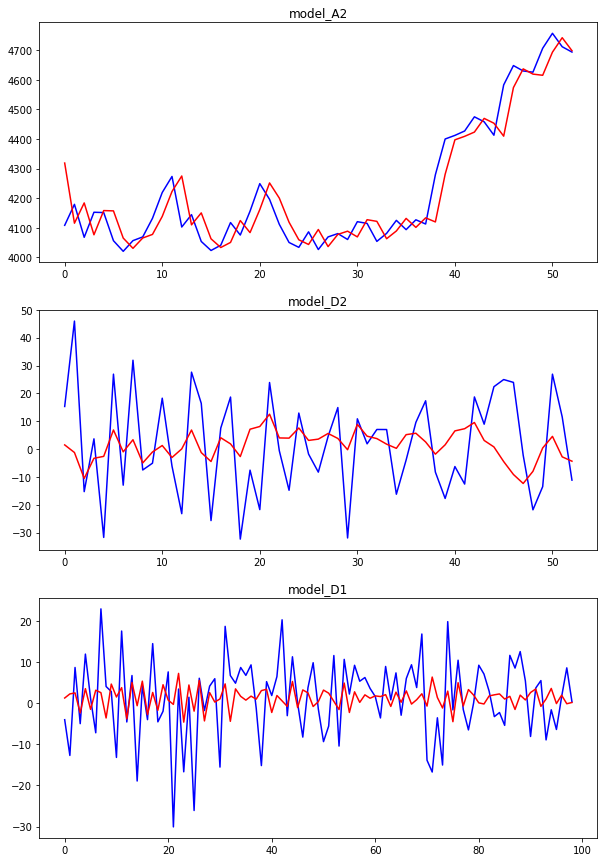

In [35]:
# 画出每层的拟合曲线
plt.figure(figsize=(10,15))
plt.subplot(3, 1, 1)
plt.plot(A2, 'blue')
plt.plot(results_A2.fittedvalues,'red')
plt.title('model_A2')

plt.subplot(3, 1, 2)
plt.plot(D2, 'blue')
plt.plot(results_D2.fittedvalues,'red')
plt.title('model_D2')

plt.subplot(3, 1, 3)
plt.plot(D1, 'blue')
plt.plot(results_D1.fittedvalues,'red')
plt.title('model_D1')
plt.show()

In [38]:
A2_all,D2_all,D1_all = pywt.wavedec(data['closeIndex'].values,'db4',mode='sym',level=2) # 对所有序列分解
delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)] # 求出差值，则delta序列对应的为每层小波系数ARMA模型需要预测的步数

In [39]:
print (delta)

[2, 2, 5]


In [40]:
# 预测小波系数 包括in-sample的和 out-sample的需要预测的小波系数
pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

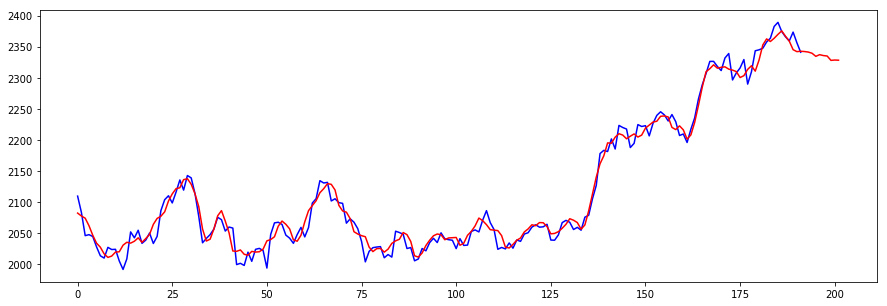

In [42]:
# 重构
coeff_new = [pA2,pD2,pD1]
denoised_index = pywt.waverec(coeff_new,'db4')

# 画出重构后的原序列预测图
plt.figure(figsize=(15,5))
plt.plot(train, 'blue')
plt.plot(denoised_index,'red')
plt.show()

In [44]:
# 10个预测值
temp_data_wt = {'real_value':test,'pre_value_wt':denoised_index[-10:],'err_wt':denoised_index[-10:]-test,'err_rate_wt/%':(denoised_index[-10:]-test)/test*100}
predict_wt = pd.DataFrame(temp_data_wt,columns=['real_value','pre_value_wt','err_wt','err_rate_wt/%'])
print (predict_wt)

   real_value  pre_value_wt     err_wt  err_rate_wt/%
0    2356.730   2342.372575 -14.357425      -0.609210
1    2339.660   2341.524995   1.864995       0.079712
2    2326.550   2339.606073  13.056073       0.561177
3    2302.420   2334.621308  32.201308       1.398585
4    2302.280   2337.293788  35.013788       1.520831
5    2290.440   2335.865156  45.425156       1.983250
6    2337.870   2335.124691  -2.745309      -0.117428
7    2373.030   2328.102640 -44.927360      -1.893249
8    2391.076   2328.671563 -62.404437      -2.609889
9    2420.180   2328.386646 -91.793354      -3.792832


In [45]:
help(pywt.wavedec)

Help on function wavedec in module pywt._multilevel:

wavedec(data, wavelet, mode='symmetric', level=None, axis=-1)
    Multilevel 1D Discrete Wavelet Transform of data.
    
    Parameters
    ----------
    data: array_like
        Input data
    wavelet : Wavelet object or name string
        Wavelet to use
    mode : str, optional
        Signal extension mode, see Modes (default: 'symmetric')
    level : int, optional
        Decomposition level (must be >= 0). If level is None (default) then it
        will be calculated using the ``dwt_max_level`` function.
    axis: int, optional
        Axis over which to compute the DWT. If not given, the
        last axis is used.
    
    Returns
    -------
    [cA_n, cD_n, cD_n-1, ..., cD2, cD1] : list
        Ordered list of coefficients arrays
        where `n` denotes the level of decomposition. The first element
        (`cA_n`) of the result is approximation coefficients array and the
        following elements (`cD_n` - `cD_1`) are 

In [48]:
print (pywt.Wavelet('db4'))

Wavelet db4
  Family name:    Daubechies
  Short name:     db
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [ ]:
# 预测函数
def wavelet_pre(index_list): 
    A2,D2,D1 = pywt.wavedec(index_list,'db4',mode='sym',level=2)  # 分解得到第4层低频部分系数和全部4层高频部分系数
    coeff = [A2,D2,D1]
    
    # 对每层小波系数求解模型系数
    order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q
    order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q
    order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']   # AIC准则求解模型阶数p,q

    # 对每层小波系数构建ARMA模型
    model_A2 =  ARMA(A2,order=order_A2)   # 建立模型
    model_D2 =  ARMA(D2,order=order_D2)
    model_D1 =  ARMA(D1,order=order_D1)

    results_A2 = model_A2.fit()
    results_D2 = model_D2.fit()
    results_D1 = model_D1.fit()
    
    #A2_all,D2_all,D1_all = pywt.wavedec(np.array(data['closeIndex']),'db4',mode='sym',level=2) # 对所有序列分解
    #delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)] # 求出差值，则delta序列对应的为每层小波系数ARMA模型需要预测的步数
    delta = [0,0,1]  # 事先计算好需要预测的步数，避免每次重复计算
    
    # 预测小波系数 包括in-sample的和 out-sample的需要预测的小波系数
    pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
    pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
    pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

    # 重构
    coeff_new = [pA2,pD2,pD1]
    denoised_index = pywt.waverec(coeff_new,'db4')
    
    return denoised_index[-3:]  # 返回预测值